In [110]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
from collections import deque # Import deque for efficient queue operations

class imageProcessor():
    def __init__(self, image_path, x_pix, y_pix):
        # Constructor to initialize the image processor object.
        # Reads the image, sets up the seed pixel and threshold values.
        
        self.readImage(image_path)  # Read the DICOM image from the given path
        self.row, self.col = self.ds.shape  # Get the dimensions of the image (rows, columns)
        
        # Normalize the image pixel values to range [0, 1] by dividing by the maximum value
        self.img_intent = self.ds / self.ds.max()  
        
        # Initialize an empty mask with the same shape as the image
        self.mask = np.empty((self.row, self.col))
        
        # Set the seed pixel (starting point) coordinates
        self.seed_row = y_pix
        self.seed_col = x_pix
        
        # Define the threshold value to be used for determining the region of interest
        self.thresh = 0.04
        
        # Calculate the upper and lower bounds for the thresholding based on the seed pixel intensity
        self.upper = self.img_intent[self.seed_row, self.seed_col] + self.thresh
        self.lower = self.img_intent[self.seed_row, self.seed_col] - self.thresh

    def readImage(self, img_path):
        # This function reads a DICOM image from the specified file path.
        # Extracts the pixel array from the image and stores it as `self.ds`.
        
        img = dicom.dcmread(img_path)  # Read the DICOM file
        self.ds = img.pixel_array  # Extract the pixel array from the DICOM image

    def threshold(self, x0, y0):
        # This function applies the threshold to the pixel at coordinates (x0, y0).
        # If the pixel's intensity is within the threshold bounds, it sets the corresponding pixel in the mask to 1.
        # Otherwise, it sets the pixel in the mask to 0.
        
        pixel = self.img_intent[y0, x0]  # Get the intensity value of the pixel at (x0, y0)
        
        # Check if the pixel value is within the upper and lower threshold bounds
        if self.lower < pixel < self.upper:
            self.mask[y0, x0] = 1  # Set the mask value to 1 (valid region)
        else:
            self.mask[y0, x0] = 0  # Set the mask value to 0 (out of region)

    def process(self):
        # This function performs the region-growing process starting from the seed pixel.
        # It spreads outward in all four directions (right, down, left, up) and processes neighboring pixels
        # if they are within the threshold bounds.
        # The process continues until there are no more pixels within the threshold region to process.
        
        # Initialize a queue for processing pixels and a set to track visited pixels to avoid revisiting
        queue = deque([(self.seed_row, self.seed_col)])  # Add the seed pixel to the queue
        visited = set([(self.seed_row, self.seed_col)])  # Mark the seed pixel as visited

        # Apply the threshold to the seed pixel and set it in the mask
        self.threshold(self.seed_col, self.seed_row)

        # Directions for exploring neighboring pixels (right, down, left, up)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up

        # Start the region-growing process
        while queue:
            x, y = queue.popleft()  # Get the current pixel from the front of the queue

            # Explore all neighboring pixels (right, down, left, up)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy  # Calculate the coordinates of the neighboring pixel

                # Check if the neighboring pixel is within the bounds of the image and not already visited
                if 0 <= nx < self.row and 0 <= ny < self.col and (nx, ny) not in visited:
                    # Check if the neighboring pixel is within the threshold bounds
                    if self.lower < self.img_intent[nx, ny] < self.upper:
                        # Mark the neighboring pixel as visited and add it to the queue for further processing
                        visited.add((nx, ny))
                        queue.append((nx, ny))
                        
                        # Apply the threshold to the neighboring pixel and set it in the mask
                        self.threshold(ny, nx)


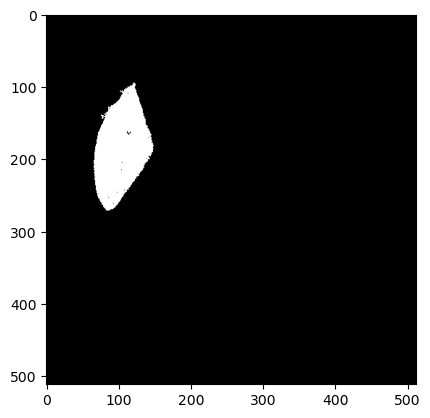

In [115]:
image_1 = imageProcessor('CT_data/i0090,0000b.dcm', 100, 200)

image_1.process()
plt.imshow(image_1.mask, 'gray')

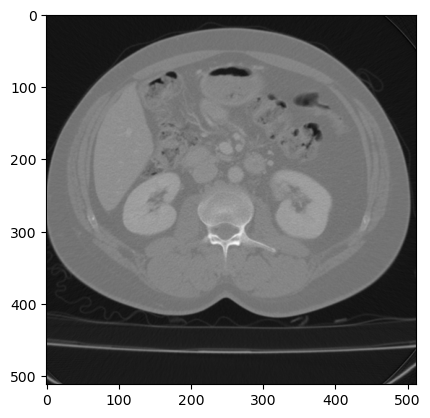

In [121]:
# plot original CT scan for reference
ds = dicom.dcmread('CT_data/i0090,0000b.dcm')
plt.imshow(ds.pixel_array, 'grey')

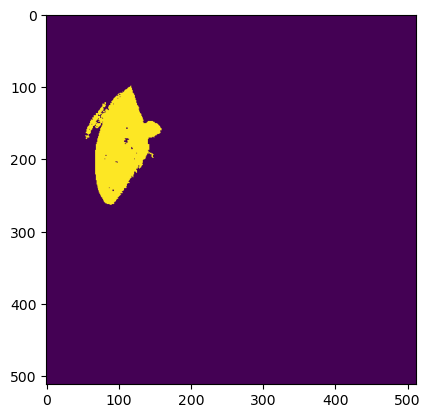

In [126]:
img_2 = imageProcessor('CT_data/i0095,0000b.dcm', 100, 200)
img_2.process()
plt.imshow(img_2.mask)

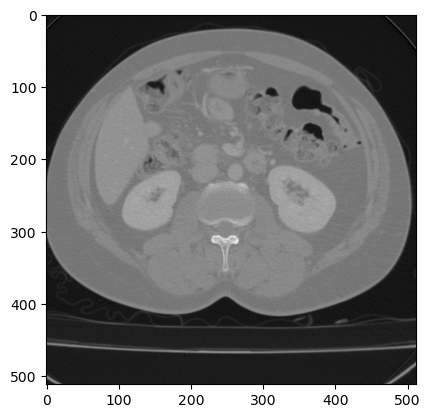

In [125]:
# plot original CT scan for reference
ds = dicom.dcmread('CT_data/i0095,0000b.dcm')
plt.imshow(ds.pixel_array, 'grey')

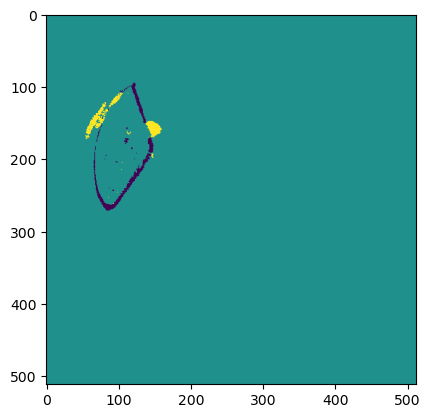

In [127]:
plt.imshow(img_2.mask - image_1.mask)